# PARTE I

## Importar bibliotecas e pacotes relevantes

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, shapiro
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import scatter_matrix

## Leitura da base de dados

In [0]:
path = '/content/drive/My Drive/PUC/Pós/TEP/Exercício 1/'
filename = 'cardio - BD.xlsx'

df = pd.read_excel(path + filename, index_col=0)
df.head()

,Idade,Sexo,IMC,ccintura,cquadril,frqCardiaca,fumo,atvFisica,stress,pdiasto
ID,,,,,,,,,,
1,20,Masculino,27.94,95,112,75,0,2,3,80.00
2,31,Feminino,28.76,88,101,66,0,2,0,74.33
3,19,Masculino,25.35,79,102,69,0,2,0,70.00
4,20,Masculino,20.73,91,80,85,0,0,0,76.67
5,19,Masculino,24.54,83,98,72,0,2,0,80.00


## I – Classifique cada variável envolvida no problema.


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 10 columns):
Idade          400 non-null int64
Sexo           400 non-null object
IMC            400 non-null float64
ccintura       400 non-null int64
cquadril       400 non-null int64
frqCardiaca    400 non-null int64
fumo           400 non-null int64
atvFisica      400 non-null int64
stress         400 non-null int64
pdiasto        400 non-null float64
dtypes: float64(2), int64(7), object(1)
memory usage: 34.4+ KB


In [0]:
# Classificação das variáveis
quali = ['Sexo', 'fumo', 'atvFisica', 'stress']
quanti = ['Idade', 'IMC', 'ccintura', 'cquadril', 'frqCardiaca', 'pdiasto']

In [0]:
dfQuanti = df.loc[:, quanti]
dfQuali = df.loc[:, quali].astype('category')

## II – Realize uma análise descritiva individual para cada variável.

In [0]:
# Variáveis qualitativas
dfQuali.describe()

,Sexo,fumo,atvFisica,stress
count,400,400,400,400
unique,2,2,3,5
top,Feminino,0,2,0
freq,225,393,183,178


In [0]:
# Descrição das variáveis quantitativas
dfQuanti.describe().applymap(lambda x: '{0:.2f}'.format(x))

,Idade,IMC,ccintura,cquadril,frqCardiaca,pdiasto
count,400.00,400.00,400.00,400.00,400.00,400.00
mean,23.14,24.00,80.94,101.68,79.82,79.11
std,6.03,4.27,11.32,8.91,11.79,12.32
min,16.00,16.23,48.00,70.00,47.00,7.00
25%,19.00,21.07,73.00,95.00,72.00,70.58
50%,21.00,23.32,79.00,101.00,80.00,78.33
75%,25.00,26.21,87.00,107.00,87.00,86.67
max,63.00,45.15,126.00,132.00,122.00,120.00


## III– Construa uma matriz de correlação com as variáveis quantitativas. Avalie quais correlações são significativas. Determine qual variável está mais correlacionada com a Pressão diastólica.

In [0]:
def pearson_pvalue(x, y):
  '''Função 'callable' para retornar o valor p
  de uma correlação entre x e y'''
  return pearsonr(x, y)[1]

In [0]:
# Correlações das variáveis
correlations = dfQuanti.corr(method='pearson')
p_values = dfQuanti.corr(method=pearson_pvalue)

'''# Filtro para apenas a matriz triangular inferior
mask = np.tril(np.ones(correlations.shape), k=-1).astype(np.bool)

correlations.where(mask, inplace=True)
p_values.where(mask, inplace=True)'''

# Considerando significativa uma correlação com |R²| >= k
k = 0
correlations[abs(correlations) >= k]

,Idade,IMC,ccintura,cquadril,frqCardiaca,pdiasto
Idade,1.000000,0.200772,0.255931,0.126026,-0.101436,0.195743
IMC,0.200772,1.000000,0.845674,0.832651,0.121858,0.303754
ccintura,0.255931,0.845674,1.000000,0.747500,0.089398,0.300848
cquadril,0.126026,0.832651,0.747500,1.000000,0.134743,0.254350
frqCardiaca,-0.101436,0.121858,0.089398,0.134743,1.000000,0.091573
pdiasto,0.195743,0.303754,0.300848,0.254350,0.091573,1.000000


In [0]:
dfQuanti.corr(method='pearson').style.background_gradient(cmap='RdBu_r', axis=None).set_precision(3)
#correlations.fillna(0).style.background_gradient(cmap='RdBu_r', axis=None)

,Idade,IMC,ccintura,cquadril,frqCardiaca,pdiasto
Idade,1,0.201,0.256,0.126,-0.101,0.196
IMC,0.201,1,0.846,0.833,0.122,0.304
ccintura,0.256,0.846,1,0.747,0.0894,0.301
cquadril,0.126,0.833,0.747,1,0.135,0.254
frqCardiaca,-0.101,0.122,0.0894,0.135,1,0.0916
pdiasto,0.196,0.304,0.301,0.254,0.0916,1


In [0]:
p_values.style.background_gradient(cmap='RdBu_r', axis=None).set_precision(3)

,Idade,IMC,ccintura,cquadril,frqCardiaca,pdiasto
Idade,1,5.25e-05,2.11e-07,0.0116,0.0426,8.12e-05
IMC,5.25e-05,1,1.37e-110,3.43e-104,0.0147,5.53e-10
ccintura,2.11e-07,1.37e-110,1,1.04e-72,0.0741,8.2e-10
cquadril,0.0116,3.43e-104,1.04e-72,1,0.00696,2.52e-07
frqCardiaca,0.0426,0.0147,0.0741,0.00696,1,0.0673
pdiasto,8.12e-05,5.53e-10,8.2e-10,2.52e-07,0.0673,1


In [0]:
# Variável mais correlacionada com 'PDiasto'
correlations[correlations != 1].loc['pdiasto'].nlargest(1)

IMC    0.303754
Name: pdiasto, dtype: float64

## IV – Construa um modelo de regressão com todas as variáveis qualitativas e quantitativas.

- Analise a tabela ANOVA para o modelo.
- Determine quais as variáveis são significativas.
- Interprete o parâmetro de qualidade de ajuste R².
- Faça uma análise de resíduos.


### a) Construção do modelo (I)

In [0]:
# Para incluir variáveis categóricas é necessário convertê-las em binárias no DF original
# Técnica: 'One Hot Encoding'

# DataFrame com todas as variaveis categóricas 'binarizadas'
'''drop_first é usado para remover uma das colunas de cada categoria, evitando multicolinearidade
uma vez que em cada caso, uma das variáveis pode ser calculada (prevista) pelo valor das outras'''
dfDummies = pd.get_dummies(df, columns=quali, drop_first=True)

In [0]:
# Construção do modelo linear usando Statsmodel OLS
X = dfDummies.drop('pdiasto', axis=1)
y = dfDummies['pdiasto']

# Adicionar manualmente opção para aplicar regressão com coeficiente linear
x = sm.add_constant(X)

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                pdiasto   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     6.231
Date:                Sat, 07 Mar 2020   Prob (F-statistic):           1.15e-10
Time:                        15:31:53   Log-Likelihood:                -1533.3
No. Observations:                 400   AIC:                             3095.
Df Residuals:                     386   BIC:                             3151.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             44.6389      8.875      5.

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
def print_anova(m):
  print('TABELA ANOVA\n')
  data = [('Modelo', m.ess, m.df_model, m.mse_model, m.fvalue),
          ('Resíduo', m.ssr, m.df_resid, m.mse_resid)]
  labels = ['Variação', 'Soma de Quadrados', 'Graus de Liberdade', 'Erro médio', 'Valor F']
  df = pd.DataFrame.from_records(data, columns=labels).set_index('Variação')
  print(df.apply(lambda x: round(x, 2)).head(2))

In [0]:
# Tabela ANOVA
print_anova(model)

TABELA ANOVA

          Soma de Quadrados  Graus de Liberdade  Erro médio  Valor F
Variação                                                            
Modelo             10496.25                13.0      807.40     6.23
Resíduo            50018.54               386.0      129.58      NaN


### b) Determinação das variáveis significativas

In [0]:
df_sig = pd.DataFrame(model.pvalues[1:],
                      columns=['Valor-p'])
df_sig['Significativo ?'] = df_sig['Valor-p'].apply(lambda x: 'Sim' if x < 0.05 else 'Não')
df_sig

,Valor-p,Significativo ?
Idade,0.001888,Sim
IMC,0.019285,Sim
ccintura,0.246383,Não
cquadril,0.453241,Não
frqCardiaca,0.027703,Sim
Sexo_Masculino,0.000018,Sim
fumo_1,0.441765,Não
atvFisica_1,0.412778,Não
atvFisica_2,0.422829,Não
stress_1,0.536894,Não


Resultados relevantes do modelo:

- Valor p << 0.05, indica resultado significativo

- Apenas 4 variáveis (além do coeficiente linear) apresentaram valor-p < 0.05, indicando boa significância:
> Os coeficientes podem ser úteis para prever como sua variação afeta a variável resposta
  - Idade
  - IMC
  - frqCardiaca
  - Sexo_Masculino

- Como previsto pela matriz de correlações, as fortes relações entre variáveis explicativas geraram problemas associados a multicolinearidade
> IMC, Ccintura e Cquadril

- Apenas o sexo, dentre as variáveis categóricas, apresentou resultados significativos para ser considerada relevante

### c) Interpretação dos parâmetros do ajuste R²

In [0]:
print(model.rsquared, model.rsquared_adj)

0.1734492783649514 0.14561207789537733


- R² = 0.173 e R²(ajustado) = 0.146
> Indício que o modelo não se ajusta bem à variabilidade em torno da média 

> A precisão das previsões do modelo não é boa (apesar de aceitável para alguns tipos de estudo), de forma que o IC de um dado previsto terá alta variabilidade


### d) Análise de resíduos

A ideia principal é avaliar a natureza aleatória, variância e distribuição dos resíduos.

O ajuste linear deve levar em consideração as hipóteses de:
- Linearidade
- Independência dos resíduos
- Homocedasticidade (variância constante)
- Normalidade dos resíduos
- Ausência de multicolinearidade (regressão múltipla)

#### d.1) Plot Resíduos x Variáveis preditivas

Objetivo: Checar independência dos resíduos
> A suposição é válida caso os resíduos estejam distribuídos aleatoriamente em torno do eixo x=0.

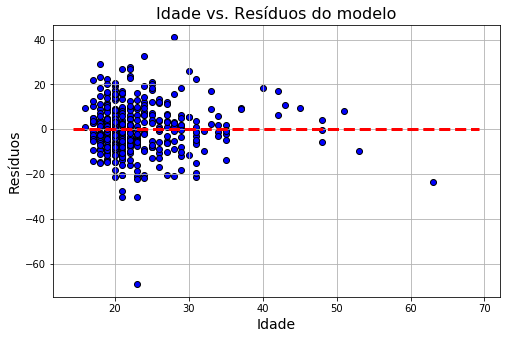

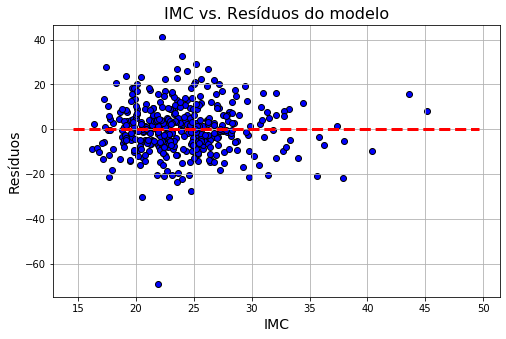

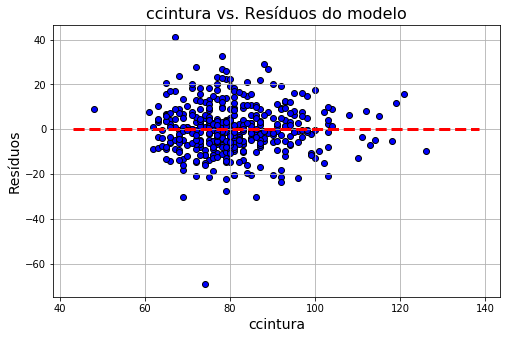

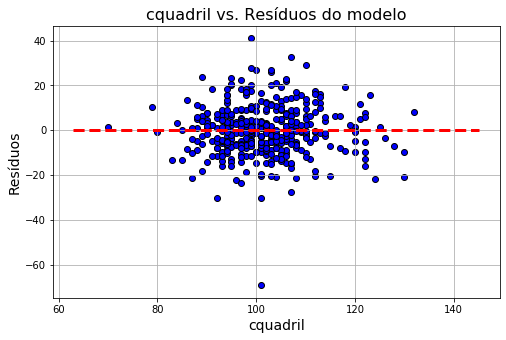

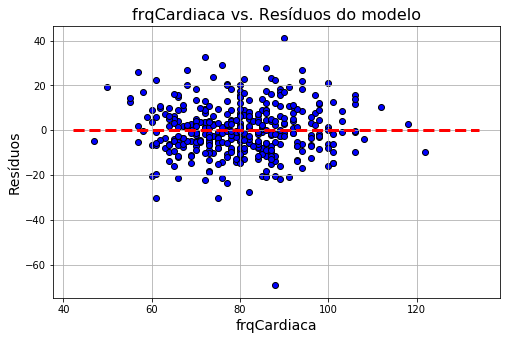

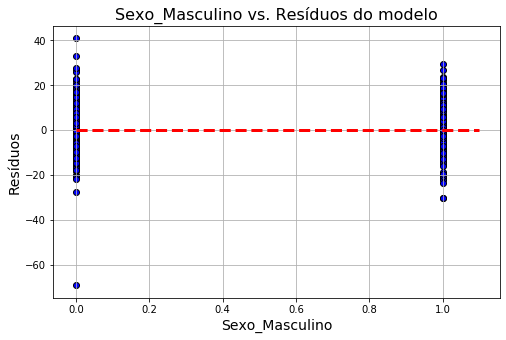

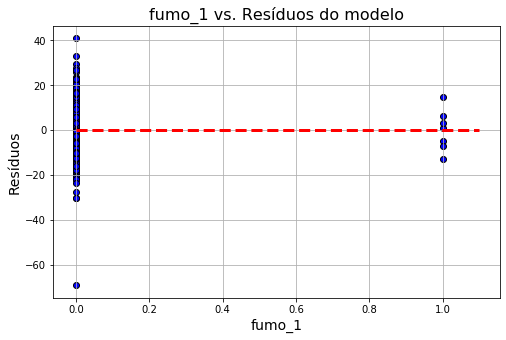

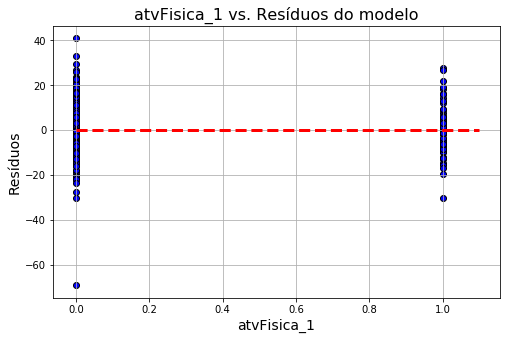

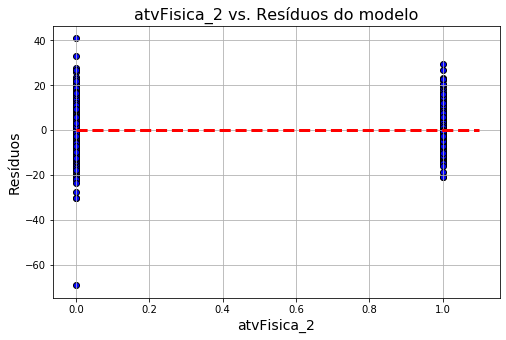

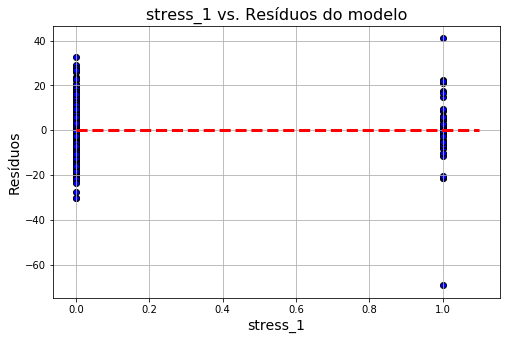

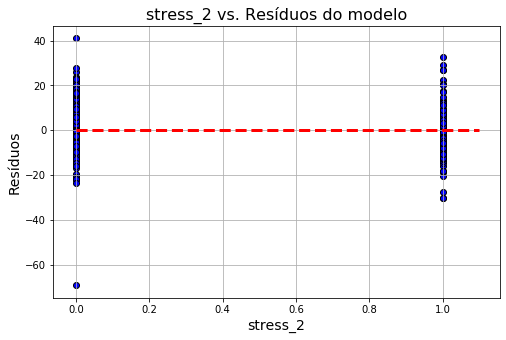

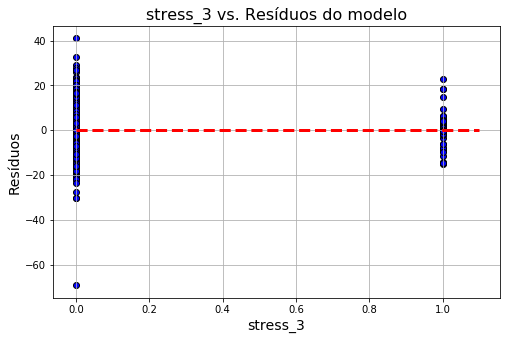

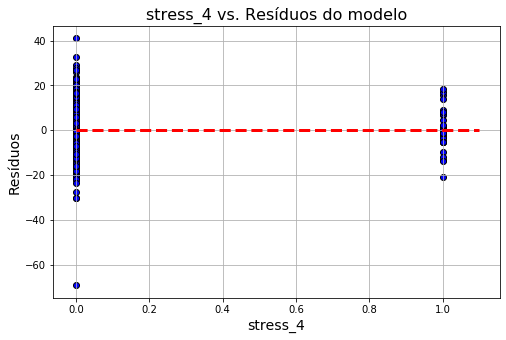

In [0]:
for c in X.columns:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. Resíduos do modelo".format(c), fontsize=16)
    plt.scatter(x=X[c], y=model.resid, color='blue', edgecolor='k')
    plt.grid(True)
    xmin = min(X[c])
    xmax = max(X[c])
    plt.hlines(y=0, xmin=0.9*xmin, xmax=1.1*xmax,
               color='red', linestyle='--', lw=3)
    plt.xlabel(c, fontsize=14)
    plt.ylabel('Resíduos', fontsize=14)
    plt.show()

#### d.2) Plot Ajuste vs. resíduos

Objetivo: Checar homocedasticidade
> A variância dos resíduos deve permanecer constante independentemente dos valores ajustados

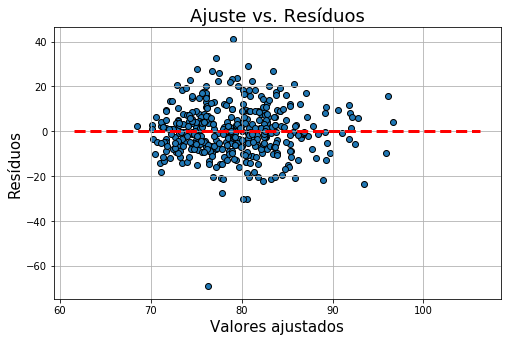

In [0]:
plt.figure(figsize=(8,5))
p = plt.scatter(x=model.fittedvalues, y=model.resid, edgecolor='k')
xmin = min(model.fittedvalues)
xmax = max(model.fittedvalues)
plt.hlines(y=0, xmin=0.9*xmin, xmax=1.1*xmax, 
           color='red', linestyle='--', lw=3)
plt.xlabel("Valores ajustados", fontsize=15)
plt.ylabel("Resíduos", fontsize=15)
plt.title("Ajuste vs. Resíduos", fontsize=18)
plt.grid(True)
plt.show()

#### d.3) Histograma dos resíduos normalizados

Objetivo: Checar normalidade dos resíduos

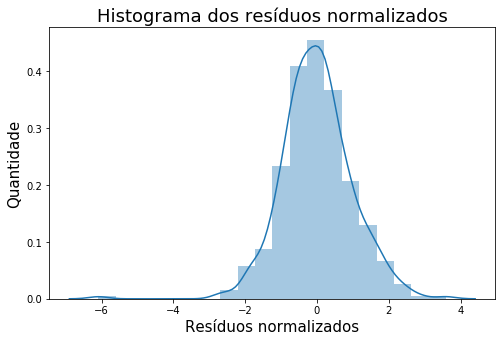

In [0]:
plt.figure(figsize=(8,5))
#plt.hist(model.resid_pearson, bins=20, edgecolor='k')
sns.distplot(model.resid_pearson, bins=20)
plt.ylabel('Quantidade', fontsize=15)
plt.xlabel('Resíduos normalizados', fontsize=15)
plt.title("Histograma dos resíduos normalizados", fontsize=18)
plt.show()

#### d.4) Plot Q-Q dos resíduos

Objetivo: Checar normalidade dos resíduos

<Figure size 576x360 with 0 Axes>

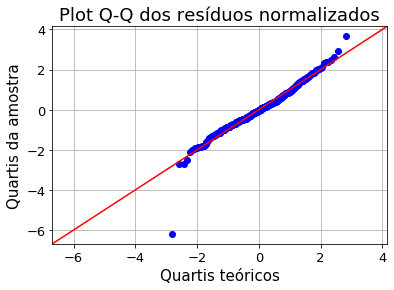

In [0]:
plt.figure(figsize=(8,5))
fig = qqplot(model.resid_pearson, line='45', fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Quartis teóricos", fontsize=15)
plt.ylabel("Quartis da amostra", fontsize=15)
plt.title("Plot Q-Q dos resíduos normalizados", fontsize=18)
plt.grid(True)
plt.show()

### d.5) Shapiro-Wilk

Teste adicional para avaliar normalidade

In [0]:
# Valor p deve ser significativo (p < 0.05)
_, p = shapiro(model.resid)
print(p)

1.3440815394005767e-07


## V – Construa um modelo de regressão com todas as variáveis qualitativas e quantitativas significativas.
- Analise a tabela ANOVA
- Interprete os parâmetros do modelo.
- Escreva o modelo ajustado.
- Interprete os parâmetros de qualidade de ajuste R².
- Faça uma análise de resíduos.
- Realize a predição da pressão diastólica para a observação de ID = 5.

### a) Construção do modelo (I)

In [0]:
# Construção do modelo linear usando Statsmodel OLS
# Considerando apenas as variáveis 'significativas' para o modelo
col = df_sig.loc[df_sig['Significativo ?'] == 'Sim'].index.values
X = dfDummies.loc[:, col]
y = dfDummies['pdiasto']

# Adicionar manualmente opção para aplicar regressão com coeficiente linear
x = sm.add_constant(X)

model2 = sm.OLS(y, x).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                pdiasto   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     19.08
Date:                Sat, 07 Mar 2020   Prob (F-statistic):           2.34e-14
Time:                        16:20:07   Log-Likelihood:                -1536.1
No. Observations:                 400   AIC:                             3082.
Df Residuals:                     395   BIC:                             3102.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             45.4564      5.189      8.

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### b) Interpretação dos parâmetros do modelo

In [0]:
# Tabela ANOVA
print_anova(model2)

TABELA ANOVA

          Soma de Quadrados  Graus de Liberdade  Erro médio  Valor F
Variação                                                            
Modelo              9797.09                 4.0     2449.27    19.08
Resíduo            50717.70               395.0      128.40      NaN


Resultados comparativos ao primeiro modelo:

- Valor p << 0.05, indica resultado significativo

- Maior valor F

- O valor-p se tornou menor para algumas variáveis, mantendo o nível satisfatório de significância
> Os coeficientes indicam correlação positiva com a pressão diastólica, de forma que a variação provoca aumento da variável resposta

- O Sexo se mostrou a variável que mais afeta a pressão diastólica ser maior, cerca de 5 unidades pelo fato de ser homem

- Após a exclusão das variáveis 'Ccintura' e 'Cquadril', as questões associadas a multicolinearidade entre variáveis explicativas foram solucionadas

#### c) Modelo ajustado

In [0]:
model_str = ' + '.join([str(x) + '*' + y for x, y in zip(round(model2.params[1:], 3), X.columns)])
const = str(round(model2.params[0], 3))
print(y.name + ' = ' + const + ' + ' + model_str)

pdiasto = 45.456 + 0.29*Idade + 0.627*IMC + 0.119*frqCardiaca + 5.483*Sexo_Masculino


In [0]:
(((1 + model2.params[1:].values/model2.params[0]) -1) * 100).round(1)

array([ 0.6,  1.4,  0.3, 12.1])

### d) Interpretação dos parâmetros do ajuste R²

In [0]:
print(model.rsquared, model.rsquared_adj)

0.16189577807838162 0.15340864671715004


- R² = 0.162 e R²(ajustado) = 0.153
> O valor do coeficiente de ajuste diminuiu, mantendo o baixo desempenho do modelo em se ajustar à variabilidade em torno da média.

> A precisão das previsões do modelo não é boa (apesar de aceitável para alguns tipos de estudo), de forma que o IC de um dado previsto terá alta variabilidade


### e) Análise de resíduos

#### e.1) Plot Resíduos x Variáveis preditivas

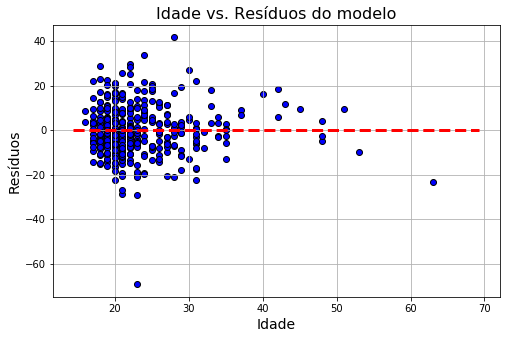

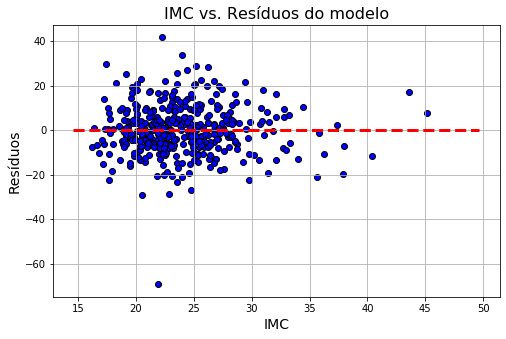

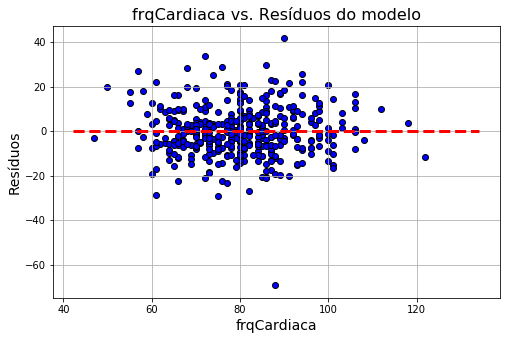

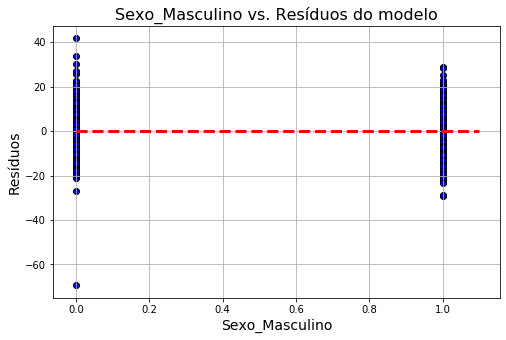

In [0]:
for c in X.columns:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. Resíduos do modelo".format(c), fontsize=16)
    plt.scatter(x=X[c], y=model.resid, color='blue', edgecolor='k')
    plt.grid(True)
    xmin = min(X[c])
    xmax = max(X[c])
    plt.hlines(y=0, xmin=0.9*xmin, xmax=1.1*xmax,
               color='red', linestyle='--', lw=3)
    plt.xlabel(c, fontsize=14)
    plt.ylabel('Resíduos', fontsize=14)
    plt.show()

#### e.2) Plot Fitted vs. residuals

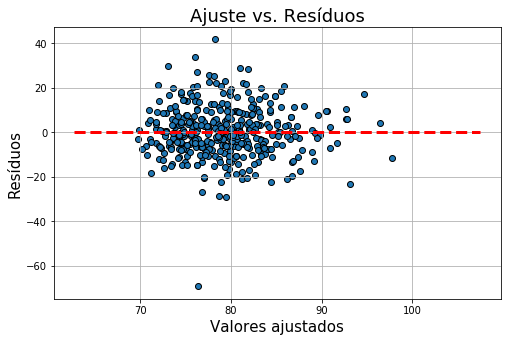

In [0]:
plt.figure(figsize=(8,5))
p = plt.scatter(x=model.fittedvalues, y=model.resid, edgecolor='k')
xmin = min(model.fittedvalues)
xmax = max(model.fittedvalues)
plt.hlines(y=0, xmin=0.9*xmin, xmax=1.1*xmax, 
           color='red', linestyle='--', lw=3)
plt.xlabel("Valores ajustados", fontsize=15)
plt.ylabel("Resíduos", fontsize=15)
plt.title("Ajuste vs. Resíduos", fontsize=18)
plt.grid(True)
plt.show()

#### e.3) Histograma dos resíduos normalizados

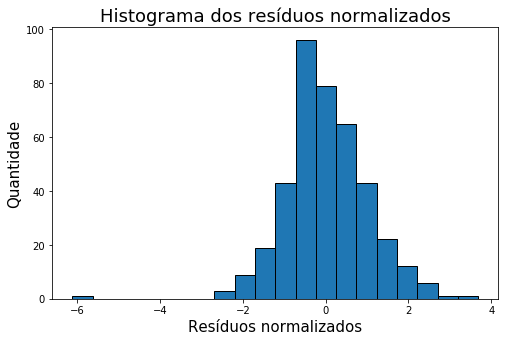

In [0]:
plt.figure(figsize=(8,5))
plt.hist(model.resid_pearson, bins=20, edgecolor='k')
plt.ylabel('Quantidade', fontsize=15)
plt.xlabel('Resíduos normalizados', fontsize=15)
plt.title("Histograma dos resíduos normalizados", fontsize=18)
plt.show()

#### e.4) Plot Q-Q dos resíduos

<Figure size 576x360 with 0 Axes>

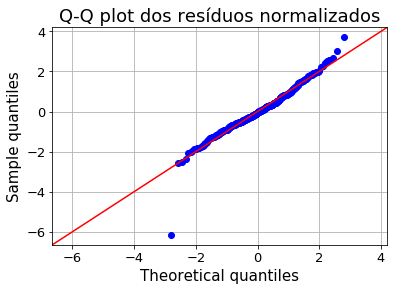

In [0]:
plt.figure(figsize=(8,5))
fig = qqplot(model.resid_pearson, line='45', fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles", fontsize=15)
plt.ylabel("Sample quantiles", fontsize=15)
plt.title("Q-Q plot dos resíduos normalizados", fontsize=18)
plt.grid(True)
plt.show()

#### e.5) Shapiro-Wilk

Teste adicional para avaliar normalidade

In [0]:
# Valor p deve ser significativo (p < 0.05)
_, p = shapiro(model.resid)
print(p)

1.0138909090073867e-07


### f) Predição ID = 5

In [0]:
x_pred = list(dfDummies.loc[5, col].to_numpy())
x_pred.insert(0, 1)
pdiast_pred = model.predict(x_pred).round(3)
pdiast_ci = model.get_prediction(x_pred).conf_int().round(3)

print('Valor previsto para ID = 5:\n')
print(f'p_diast = {pdiast_pred}')
print(f'IC = {pdiast_ci[0]}\n')

# Valor real
pdiast_ref = df.loc[5, 'pdiasto']
print(f'p_diast ID 5 = {pdiast_ref}')

Valor previsto para ID = 5:

p_diast = [80.409]
IC = [78.394 82.424]

p_diast ID 5 = 80.0


In [0]:
print(['Intervalo de confiança para uma nova observação'])
pdiast_ci_obs = model.get_prediction(x_pred).conf_int(obs=True).round(3)

print(f'IC = {pdiast_ci_obs[0]}\n')

['Intervalo de confiança para uma nova observação']
IC = [ 58.041 102.777]

